In [1]:
import shutil
import matplotlib.pyplot as plt

import numpy as np
import os
import cv2
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten
from sklearn.model_selection import train_test_split
from keras_buoy.models import ResumableModel

# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# Gibt die Pfade zum Einlesen der Bilder und Labels an
srcpath_images = "C:/Users/DanielWeller/Desktop/Testdaten/"
srcpath_label_infos = "C:/Users/DanielWeller/Desktop/Wand_Label_Infos/"
# Wie heißt die CSV Datei in der die Labelinfos gespeichert sind
csv_name = "Wand_Label_Info3.csv"
# Spalte in der CSV Datei in der die Labelinfos gespeichert sind. Achtung counter beginnt mit 0
csv_spalte_labelinfo = 17


# Gibt die Zielpfade an
destpath_dir = "C:/Users/DanielWeller/Desktop/Training1/"
# Gibt die Pfade zum Zwischenspeichern der verwendeten Bilder an
# VORSICHT! ORDNER WERDEN BEIM START DES SKRIPTS GELÖSCHT/GELEERT!
destpath_train_images = destpath_dir + "Dataset/Trainset/"
destpath_test_images = destpath_dir + "Dataset/Testset/"
#Gibt den Pfad zum speichern des trainierten Modells an
modelsavetemppath = destpath_dir + "models/temp/"
modelsavepathfinal = destpath_dir + "models/final/"


# Zwischenspeichern des Modells: Include the epoch in the file name (uses `str.format`)
# checkpoint_path = "D:/Modells/Zwischenspeicher/Training1/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)




###################################################################
# Werte für die Resize Funktion
###################################################################
# Zukünftige Maße für Querformat festlegen 
widthquer = 400
heightquer = 300
# Zukünftige Maße für Hochformat festlegen 
widthhoch = 300
heighthoch = 400


###################################################################
# Werte, Listen und Variablen zur Verteilung des Train-/Testsplits
###################################################################
# Gibt das Verhältnis vom Train- zum Testsplit an
faktorTrainSplit = 0.7
# Hilfslisten und Variablen zur Verteilung des Train-/Testsplits
waende_alle = []
waende_train = []
waende_test = []
# Arrays für die Images des Train- und Testsplits
x_train_material = []
x_test_material = []
# Arrays für die Labels des Train- und Testsplits
y_train_material = []
y_test_material = []
# Hilfsarray um die Dateinamen aller verwendeten Bilder zwischenzuspeichern
images_train_filenames = []
images_test_filenames = []
images_all_filenames = []


##################################################################################
# Methode in der die Parameter definiert werden, welche Bilder verwendet werden sollen
##################################################################################
def ImageIsInFilter(splittedfilename):
    # Welche Images sollen aus dem vorher angegebenen SrcOrdner verwendet werden. Gefiltert wird nach den Flags im Dateinamen
    if (
    # Prüft an Stelle 13 des Dateinamens auf das Flag "1". Damit werden nur Bilder geladen die mit dem Smartphone aufgenommen wurden
    (splittedfilename[13] == str(1)) and
    # Prüft an Stelle 14 des Dateinamens auf das Flag "1". Damit werden nur Bilder geladen die im Querformat vorliegen.
    (splittedfilename[14] == str(1)) and
    # Prüft an Stelle 15 des Dateinamens auf das Flag "1", "2" und "3". Damit werden nur Bilder geladen die ohne, mit rotem, oder Drei Aruco Sticker aufgenommen wurden.
    ( (splittedfilename[15] == str(1)) or (splittedfilename[15] == str(2)) or (splittedfilename[3] == str(1)) or (splittedfilename[4] == str(1)) )
    ):
        return True
    return False



##################################################################################
# Leert die Ordner der Train- und Testbilder
##################################################################################
if os.path.exists(destpath_train_images):
    shutil.rmtree(destpath_train_images, ignore_errors = False) 
os.makedirs(destpath_train_images)
if os.path.exists(destpath_test_images):
    shutil.rmtree(destpath_test_images, ignore_errors = False) 
os.makedirs(destpath_test_images)



##################################################################################
# Wand-Label-Info-CSV in NP Array einlesen
##################################################################################
# eventueller Parameter: usecols = (0,1,2,3,4,5,6)
# eventueller Parameter: dtype="int" 
with open(str(srcpath_label_infos)+str(csv_name)) as wand_label_info_file:
    wand_label_info = np.loadtxt(wand_label_info_file, delimiter=";", skiprows=1, dtype="int")
#print(wand_label_info)





##################################################################################
# Baustellen und Wand ID aus Dateinamen laden um Train/Testsplit auf Wandebene vorzubereiten
##################################################################################
for filename in os.listdir(srcpath_images):
    # Trennt den Filename in den reinen Filename und Extension
    filenameshort, extension = os.path.splitext(filename)
    # Prüft ob Datei .jpg ist
    if extension == ".jpg":
        # Splitted den Dateinamen mit dem Trennoperator "_" und speichert den Inhalt in eine Liste
        splittedfilename = filenameshort.split("_")
        # Speichert die Baustellennummer und Wandnummer zwischen
        img_baustellenID = splittedfilename[1]
        img_wandID = splittedfilename[2]
        img_baustellenUndWandID = img_baustellenID+"_"+img_wandID
        # Welche Images sollen aus dem vorher angegebenen SrcOrdner verwendet werden. Gefiltert wird nach den Flags im Dateinamen
        if (ImageIsInFilter(splittedfilename)):
            if img_baustellenUndWandID not in waende_alle:
                waende_alle.append(img_baustellenUndWandID)              
print("Anzahl aller verwendeten Wände/Szenen: "+str(len(waende_alle)))
# Bestimmt die Anzahl der Wände für den Trainingssplit. Dafür wird der vorherig definierte Faktor verwendet
waende_train, waende_test = train_test_split(waende_alle, train_size=faktorTrainSplit, random_state=42)
print("Anzahl der Wände/Szenen für den Trainingssplit: "+str(len(waende_train)))
print("Anzahl der Wände/Szenen für den Testsplit: "+str(len(waende_test)))





##################################################################################
# gewünschte Bilder werden bearbeitet und dem Train- oder Testsplit hinzugefügt
##################################################################################
for filename in os.listdir(srcpath_images):
    # Trennt den Filename in den reinen Filename und Extension
    filenameshort, extension = os.path.splitext(filename)
    # Prüft ob Datei .jpg ist
    if extension == ".jpg":
        # Splitted den Dateinamen mit dem Trennoperator "_" und speichert den Inhalt in eine Liste
        splittedfilename = filenameshort.split("_")
        # Speichert die Baustellennummer und Wandnummer zwischen
        img_baustellenID = splittedfilename[1]
        img_wandID = splittedfilename[2]
        img_baustellenUndWandID = img_baustellenID+"_"+img_wandID
        # Welche Images sollen aus dem vorher angegebenen SrcOrdner verwendet werden. Gefiltert wird nach den Flags im Dateinamen
        if (ImageIsInFilter(splittedfilename)):
            # Gefilterte Bilder/Images laden
            img = cv2.imread(os.path.join(srcpath_images,filename))

            # ##################################################################################
            # # Vorbearbeitung der Bilder
            # ##################################################################################
            # imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #Bild wird schwarz weiß
            # imgBlur=cv2.GaussianBlur(imgGray,(5,5),1) #Kernel 5*5
            # # Canny Filter: Thr = For this, we need two threshold values, minVal and maxVal. Any edges with intensity gradient more than maxVal are sure to be edges and those below minVal are sure to be non-edges, so discarded.
            # imgCanny=cv2.Canny(imgBlur, 40, 40) #Cannyfilter (25, 25 guter Wert, wenn nur Canny)
            # kernel= np.ones((5,5)) #Neuer Kernel für Dilate (5*5 groß)
            # imgDial = cv2.dilate(imgCanny,kernel,iterations=2) #Erweitert das Bild (verstärkt)
            # imgThre=cv2.erode(imgDial,kernel,iterations=1) #Verfeinert das Bild (verwässert)
            # img = imgThre

            ##################################################################################
            # Resize der Bilder
            ##################################################################################
            # Resize der Bilder auf neue Maße wie zu Beginn angegeben
            # Prüft ob Bild Querformat ist
            if splittedfilename[14] == str(1):
                dim = (widthquer, heightquer)
            # Prüft ob Bild Hochformat ist
            elif splittedfilename[14] == str(2):
                dim = (widthhoch, heighthoch)
            # Resize mit neuen Dimensionen
            resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
            img = resized

            ##################################################################################
            # Bild vorbereiten für das Speichern im Array und für das einlesen ins Modell
            ################################################################################## 
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            ##################################################################################
            # Zwischenspeichern der Bilder in die zuvor angegebenen Zielordner  
            ################################################################################## 
            if img_baustellenUndWandID in waende_train:
                cv2.imwrite(os.path.join(destpath_train_images , filenameshort+'.jpg'),img)
            else:   
                cv2.imwrite(os.path.join(destpath_test_images , filenameshort+'.jpg'),img)

            ##################################################################################
            # Speichern der Bilder und der zugehörigen Labels in die Arrays des Train- und Testsets  
            ################################################################################## 
            # Prüft ob das Bild zu den Traingswänden gehört
            if img_baustellenUndWandID in waende_train:
                x_train_material.append(np.array(img))
                # Iteriert durch die Infos aus der CSV und schaut ob die BaustellenID und WandID der Dateien mit den Zeilen in der CSV matchen. Falls ja, dann soll das zugehörige 
                # Label in das Array "y_train_material" gespeichert werden. 
                for i in range(len(wand_label_info)):
                    # Prüft ob BaustellenID und WandID mit den Spalten in der CSV übereinstimmen.
                    if (
                        str(wand_label_info[i][0]) == img_baustellenID and
                        str(wand_label_info[i][1]) == img_wandID
                    ):
                        # Fügt den Wert der gewählten Spalte in der CSV dem Array "y_train_material" hinzu
                        y_train_material.append(np.array(wand_label_info[i][csv_spalte_labelinfo]))
                # Den Dateinamen des gefilterten Traings-Images in einem Array speichern. Für spätere Kontrolle nützlich
                images_train_filenames.append(np.array(filenameshort))
            # Wenn das Bild nicht zu den Trainingswänden gehört, gehört es zu den Testwänden          
            else:
                x_test_material.append(np.array(img))
                # Iteriert durch die Infos aus der CSV und schaut ob die BaustellenID und WandID der Dateien mit den Zeilen im Array aus der eingelesen CSV matchen. Falls ja, dann soll das zugehörige 
                # Label in das Array "y_test_material" gespeichert werden. 
                for i in range(len(wand_label_info)):
                    # Prüft ob BaustellenID und WandID mit den Spalten in dem Array der eingelesen CSV übereinstimmen.
                    if (
                        str(wand_label_info[i][0]) == img_baustellenID and
                        str(wand_label_info[i][1]) == img_wandID
                    ):
                        # Fügt den Wert der gewählten Spalte in der CSV dem Array "y_test_material" hinzu
                        y_test_material.append(np.array(wand_label_info[i][csv_spalte_labelinfo]))
                # Den Dateinamen des gefilterten Test-Images in einem Array speichern. Für spätere Kontrolle nützlich
                images_test_filenames.append(np.array(filenameshort))
            # Den Dateinamen des gefilterten Images in einem Array speichern in dem alle verwendeten Dateinamen gespeichert werden. Für spätere Kontrolle nützlich
            images_all_filenames.append(np.array(filenameshort))

##################################################################################
# Konvertierung in NP Arrays
################################################################################## 
images_train_filename = np.array(images_train_filenames)
images_test_filenames = np.array(images_test_filenames)
images_all_filenames = np.array(images_all_filenames)
x_train_material = np.array(x_train_material)
y_train_material = np.array(y_train_material)
x_test_material = np.array(x_test_material)
y_test_material = np.array(y_test_material)

##################################################################################
# Ausgabe der Werte auf der Konsole
################################################################################## 
print()
print("Anzahl aller verwendeter Bilder: "+str(len(images_all_filenames)))
print()
print("Traingset:")
print("Anzahl der im Array x_train_material gespeicherten Bilder: "+str(len(x_train_material)))
print("Anzahl der im Array y_train_material gespeicherten Labels: "+str(len(y_train_material)))
print("y_train_material Min: "+str(np.amin(y_train_material)))
print("y_train_material Max: "+str(np.amax(y_train_material)))
print("y_train_material Mean: "+str(np.mean(y_train_material)))
print()
print("Testset:")
print("Anzahl der im Array x_test_material gespeicherten Bilder: "+str(len(x_test_material)))
print("Anzahl der im Array y_test_material gespeicherten Labels: "+str(len(y_test_material)))
print("y_test_material Min: "+str(np.amin(y_test_material)))
print("y_test_material Max: "+str(np.amax(y_test_material)))
print("y_test_material Mean: "+str(np.mean(y_test_material)))





Anzahl aller verwendeten Wände/Szenen: 45
Anzahl der Wände/Szenen für den Trainingssplit: 31
Anzahl der Wände/Szenen für den Testsplit: 14

Anzahl aller verwendeter Bilder: 281

Traingset:
Anzahl der im Array x_train_material gespeicherten Bilder: 200
Anzahl der im Array y_train_material gespeicherten Labels: 200
y_train_material Min: 7290
y_train_material Max: 228400
y_train_material Mean: 75549.45

Testset:
Anzahl der im Array x_test_material gespeicherten Bilder: 81
Anzahl der im Array y_test_material gespeicherten Labels: 81
y_test_material Min: 8710
y_test_material Max: 237200
y_test_material Mean: 73974.93827160494


In [4]:
##################################################################################
# Definieren des Modells
################################################################################## 
material_model = Sequential([

    #size=3 -> 3X3 Matrix
    #Input Shape (bsp 3) bedeutet -> Eingabe sind eigentl. 3 Schichten/Bilder/Kanäle (RGB)
    #Input Spape 200, 200 -> Auflösung des Bildes 
    #kernel size ist tensor größe, bsp bei size=3 -> 3x3x3=27
    #Output ist 198 in beispiel
    Conv2D(128, kernel_size=3, activation='relu', input_shape=(300, 400, 3)),

    # Es gibt keine Tensoren, pool=size =3 -> 3x3x1 dann bestimmen größte Zahl in Block
    # danach schrittweite 2 (strides) komplett erste schicht durch, danach 128 weitere Schichten (vorgabe von vorherigen Layer)
    MaxPool2D(pool_size=3, strides=2),

    #identisch wie erster
    Conv2D(128, kernel_size=3, activation='relu'),

    MaxPool2D(pool_size=3, strides=2),

    Conv2D(256, kernel_size=3, activation='relu'),

    MaxPool2D(pool_size=3, strides=2),

    Conv2D (512, kernel_size=3, activation='relu'),

    MaxPool2D(pool_size=3, strides=2),

    # Als Input 9x9x512 Matrix wird als Kette gebildet.
    Flatten(),

    # Überanpassung soll vermieden werden. Bei jedem Durchlauf (Batch?) werden 50% (0,5) der Verbindungen ausgeblendet
    Dropout(0.5),

    #Versteckte Schicht (Hidden layer) Zielvorgabe 512
    Dense(512, activation='relu'),

    #Versteckte Schicht (Hidden layer) Zielvorgabe 1
    Dense(1, activation='linear', name='age')
])

material_model.compile(
optimizer='adam',
loss='mse',
metrics =['mae']
)


In [22]:
##################################################################################
# Printen des Modells
################################################################################## 
print(material_model.summary ())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 298, 398, 128)     3584      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 148, 198, 128)    0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 146, 196, 128)     147584    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 72, 97, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 70, 95, 256)       295168    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 34, 47, 256)     

In [5]:
##################################################################################
# Training des Modells
################################################################################## 

# Packt ein Wrapper um das Modell um es regelmäßig abzuspeichern. Dabei wird auch die History unter dem Dateipfad gespeichert
resumable_model = ResumableModel(material_model, save_every_epochs=1, to_path= (modelsavetemppath+"mymodel.h5"))

# Training des Modells
history = resumable_model.fit(
x=x_train_material, y=y_train_material, batch_size=16, verbose=2, epochs=200)

# Laden der letzten Version des Modells um damit später zu evaluieren
material_model = tf.keras.models.load_model(modelsavetemppath+"mymodel.h5")
print("Model geladen")


You want to train for 200 epochs but 200 epochs already completed; nothing to do.


Model geladen


In [6]:
##################################################################################
# Finales speichern des Modells
################################################################################## 
material_model.save(modelsavepathfinal + "material_model_final.h5")

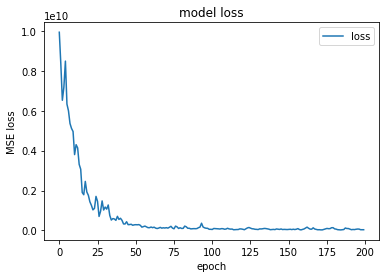

In [7]:
##################################################################################
# Plotten der Trainings-History des Modells
################################################################################## 

plt.plot(history['loss'])
#plt.plot(history['mae'])
plt.title('model loss')
plt.ylabel('MSE loss')
plt.xlabel('epoch')
plt.legend(['loss', 'mae'], loc='upper right')
plt.show()

In [8]:
##################################################################################
# Evaluieren des Modells
################################################################################## 
test_material = material_model.evaluate(x_test_material, y_test_material)

3/3 [==============================] - 79s 23s/step - loss: 2289801216.0000 - mae: 28452.6289
